# Video Transformers

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was executed in Google Colab using a A100-GPU.

### Start of execution

In [1]:
import time

In [2]:
start = time.time()

### 1. Setting the environment

In [3]:
!pip install -q torchvision==0.16

In [4]:
!pip install -q pytorchvideo==0.1.2

### 2. Import Libraries

In [5]:
import os
import torch
import imageio
import tarfile
import pathlib
import numpy as np
import pytorchvideo.data
from transformers import pipeline
from IPython.display import Image
from huggingface_hub import notebook_login
from huggingface_hub import hf_hub_download
from transformers import TrainingArguments, Trainer
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

In [6]:
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


### 3. Functions

In [7]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

In [8]:
def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

In [9]:
def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

In [10]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### 4. Load dataset

In [11]:
notebook_login()

In [12]:
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
with tarfile.open(file_path) as t:
     t.extractall(".")

In [14]:
dataset_root_path = "UCF101_subset"
dataset_root_path = pathlib.Path(dataset_root_path)

In [15]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


In [16]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
 )
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BabyCrawling/v_BabyCrawling_g08_c04.avi'),
 PosixPath('UCF101_subset/train/BabyCrawling/v_BabyCrawling_g01_c03.avi'),
 PosixPath('UCF101_subset/train/BabyCrawling/v_BabyCrawling_g15_c01.avi'),
 PosixPath('UCF101_subset/train/BabyCrawling/v_BabyCrawling_g15_c03.avi'),
 PosixPath('UCF101_subset/train/BabyCrawling/v_BabyCrawling_g02_c01.avi')]

In [17]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


### 5. Load model

In [18]:
model_ckpt = "MCG-NJU/videomae-base"
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 6. Preprocess Data

In [19]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

In [20]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

In [21]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [22]:
print(train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos)

300 30 75


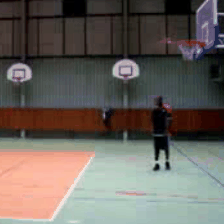

In [23]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

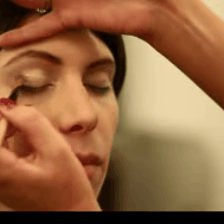

In [24]:
sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

### 7. Training

In [25]:
model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 6
batch_size = 8

In [26]:
args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    push_to_hub=True,
    max_steps = (train_dataset.num_videos // batch_size) * num_epochs
)

In [27]:
trainer = Trainer(
    model = model,
    args = args,
    data_collator = collate_fn,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = image_processor
)

max_steps is given, it will override any value given in num_train_epochs


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss
0,2.153200,1.960137
1,1.081800,1.012347
2,0.490700,0.622827
3,0.246400,0.244970
4,0.092600,0.190948
5,0.055800,0.224875


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

TrainOutput(global_step=222, training_loss=0.7850914595665427, metrics={'train_runtime': 349.1724, 'train_samples_per_second': 5.086, 'train_steps_per_second': 0.636, 'total_flos': 2.188245528623186e+18, 'train_loss': 0.7850914595665427, 'epoch': 5.1441441441441444})

In [29]:
trainer.push_to_hub()

events.out.tfevents.1727213263.18bbd82beced.18327.0:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anvaldesg/videomae-base-finetuned-ucf101-subset/commit/660d8b8fb5786912d38b9254b3edd0956cab5bca', commit_message='End of training', commit_description='', oid='660d8b8fb5786912d38b9254b3edd0956cab5bca', pr_url=None, pr_revision=None, pr_num=None)

### 8. Inference: Hugging Face

In [30]:
video_cls = pipeline(model='anvaldesg/videomae-base-finetuned-ucf101-subset', device = 'cuda')

model.safetensors:   0%|          | 0.00/345M [00:00<?, ?B/s]

In [31]:
video_cls("https://huggingface.co/datasets/sayakpaul/ucf101-subset/resolve/main/v_BasketballDunk_g14_c06.avi")

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(value)


[{'score': 0.9737687706947327, 'label': 'BasketballDunk'},
 {'score': 0.009741699323058128, 'label': 'BalanceBeam'},
 {'score': 0.0042437356896698475, 'label': 'BaseballPitch'},
 {'score': 0.0029220376163721085, 'label': 'BabyCrawling'},
 {'score': 0.002350779715925455, 'label': 'BandMarching'}]

### 9. Inference: Local

In [32]:
sample_test_video = next(iter(test_dataset))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [33]:
def run_inference(model, video):
    # (num_frames, num_channels, height, width)
    permuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": permuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [34]:
logits = run_inference(model, sample_test_video["video"])

In [35]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BasketballDunk


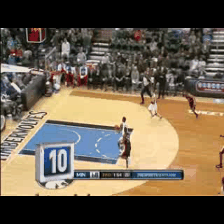

In [36]:
video_tensor = sample_test_video["video"]
display_gif(video_tensor)

### End of execution

In [37]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 6, Seconds: 49
